In [4]:
%load_ext autoreload
%autoreload 2

## 1. Imports and Setup

In [5]:
import sys
import os
import talib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../src")

from strategy import Strategy
from backtest import run_backtest

## 2. Load and clean data

In [6]:
# Load your BTC/USD hourly data
data_path = '../data/btc_hour.csv'
df = pd.read_csv(data_path)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2011-11-28 00:00:00+00:00,2.499,2.461,2.480,3457.45,8571.74,2.497,direct,NaN
1,2011-11-28 01:00:00+00:00,2.498,2.480,2.497,681.46,1698.15,2.498,direct,NaN
2,2011-11-28 02:00:00+00:00,2.499,2.485,2.498,624.29,1559.13,2.487,direct,NaN
3,2011-11-28 03:00:00+00:00,2.498,2.442,2.487,2648.16,6519.05,2.442,direct,NaN
4,2011-11-28 04:00:00+00:00,2.500,2.440,2.442,4299.98,10667.19,2.462,direct,NaN


In [7]:
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2011-11-28 00:00:00+00:00,2.499,2.461,2.480,3457.45,8.571740e+03,2.497,direct,NaN
1,2011-11-28 01:00:00+00:00,2.498,2.480,2.497,681.46,1.698150e+03,2.498,direct,NaN
2,2011-11-28 02:00:00+00:00,2.499,2.485,2.498,624.29,1.559130e+03,2.487,direct,NaN
3,2011-11-28 03:00:00+00:00,2.498,2.442,2.487,2648.16,6.519050e+03,2.442,direct,NaN
4,2011-11-28 04:00:00+00:00,2.500,2.440,2.442,4299.98,1.066719e+04,2.462,direct,NaN
...,...,...,...,...,...,...,...,...,...
118054,2025-05-16 22:00:00+00:00,103649.830,103450.360,103643.590,978.41,1.012609e+08,103551.320,direct,NaN
118055,2025-05-16 23:00:00+00:00,103718.440,103465.470,103551.320,312.40,3.235507e+07,103499.600,direct,NaN
118056,2025-05-17 00:00:00+00:00,103569.600,103141.310,103499.600,488.11,5.044067e+07,103388.020,direct,NaN
118057,2025-05-17 01:00:00+00:00,103388.090,102642.390,103388.020,669.72,6.891526e+07,102859.210,direct,NaN


In [8]:
# Data cleaning: keep only time, close, volumeto; cast time to datetime; rename volumeto to volume
df = df[['time', 'close', 'volumeto']].copy()
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'volumeto': 'volume'})
df.head()

,time,close,volume
0,2011-11-28 00:00:00+00:00,2.497,8571.74
1,2011-11-28 01:00:00+00:00,2.498,1698.15
2,2011-11-28 02:00:00+00:00,2.487,1559.13
3,2011-11-28 03:00:00+00:00,2.442,6519.05
4,2011-11-28 04:00:00+00:00,2.462,10667.19


In [9]:
df.tail()

,time,close,volume
118054,2025-05-16 22:00:00+00:00,103551.32,1.012609e+08
118055,2025-05-16 23:00:00+00:00,103499.60,3.235507e+07
118056,2025-05-17 00:00:00+00:00,103388.02,5.044067e+07
118057,2025-05-17 01:00:00+00:00,102859.21,6.891526e+07
118058,2025-05-17 02:00:00+00:00,103307.02,2.715254e+07


## 3. Define strategy

### Buy and Hold strategy

In [10]:
class BuyAndHoldStrategy(Strategy):
    def __init__(self, initial_capital=10000):
        super().__init__(initial_capital)
        self.has_bought = False

    def process_bar(self, bar):
        self.current_bar = bar

    def get_signal(self):
        if not self.has_bought:
            self.has_bought = True
            return 'buy'
        return 'hold'

### SMA Crossover Strategy

In [92]:
class SMACrossoverStrategy(Strategy):
    def __init__(self, initial_capital=10000, fast=20, slow=100):
        super().__init__(initial_capital)
        self.prices = []
        self.fast = fast
        self.slow = slow
        self.last_signal = 'hold'

    def process_bar(self, bar):
        self.current_bar = bar
        self.prices.append(bar['close'])
        if len(self.prices) < self.slow:
            self.last_signal = 'hold'
            return

        fast_ma = pd.Series(self.prices).rolling(self.fast).mean().iloc[-1]
        slow_ma = pd.Series(self.prices).rolling(self.slow).mean().iloc[-1]

        if fast_ma > slow_ma and self.position == 0:
            self.last_signal = 'buy'
        elif fast_ma < slow_ma and self.position == 1:
            self.last_signal = 'sell'
        else:
            self.last_signal = 'hold'

    def get_signal(self):
        return self.last_signal

### Exponential Moving Average (EMA) Strategy

In [97]:
class EMACrossoverStrategy(Strategy):
    def __init__(self, initial_capital=10000, fast=20, slow=100):
        super().__init__(initial_capital)
        self.fast = fast
        self.slow = slow
        self.alpha_fast = 2 / (fast + 1)
        self.alpha_slow = 2 / (slow + 1)
        self.fast_ema = None     # will hold the running EMA values
        self.slow_ema = None
        self.last_signal = 'hold'

    def process_bar(self, bar):
        price = bar['close']
        self.current_bar = bar

        # Initialise on first tick
        if self.fast_ema is None:
            self.fast_ema = price
            self.slow_ema = price
            self.last_signal = 'hold'
            return

        # Update EMAs
        self.fast_ema = price * self.alpha_fast + self.fast_ema * (1 - self.alpha_fast)
        self.slow_ema = price * self.alpha_slow + self.slow_ema * (1 - self.alpha_slow)

        # Generate signal
        if self.fast_ema > self.slow_ema and self.position == 0:
            self.last_signal = 'buy'
        elif self.fast_ema < self.slow_ema and self.position == 1:
            self.last_signal = 'sell'
        else:
            self.last_signal = 'hold'

    def get_signal(self):
        return self.last_signal


### Relative Strength Index (RSI) Strategy

In [98]:
class RSIStrategy(Strategy):
    def __init__(self, initial_capital=10000, rsi_period=14, overbought=70, oversold=30, sma_period=200):
        super().__init__(initial_capital)
        self.prices = []
        self.rsi_period = rsi_period
        self.overbought = overbought
        self.oversold = oversold
        self.sma_period = sma_period
        self.last_signal = 'hold'
        self.position = 0  # 0 = no position, 1 = long
        self.prev_rsi = None
        self.prev_sma = None

    def process_bar(self, bar):
        self.current_bar = bar
        self.prices.append(bar['close'])
        if len(self.prices) < max(self.rsi_period, self.sma_period) + 1:
            self.last_signal = 'hold'
            return

        # Calculate RSI using pandas
        prices = pd.Series(self.prices)
        delta = prices.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ma_up = up.rolling(self.rsi_period, min_periods=1).mean()
        ma_down = down.rolling(self.rsi_period, min_periods=1).mean()
        rs = ma_up / ma_down
        rsi = 100 - (100 / (1 + rs))
        current_rsi = rsi.iloc[-1]
        
        # 200-SMA calculation
        sma = prices.rolling(self.sma_period).mean()
        current_sma = sma.iloc[-1]
        prev_sma = sma.iloc[-2]

        # Buy: Only use RSI oversold
        if current_rsi < self.oversold and self.position == 0:
            self.last_signal = 'buy'
            self.position = 1
        # Sell: RSI < 40, or price < 200-SMA, or 200-SMA is falling
        elif (
            self.position == 1 and (
                current_rsi < self.overbought or
                bar['close'] < current_sma or
                current_sma < prev_sma
            )
        ):
            self.last_signal = 'sell'
            self.position = 0
        else:
            self.last_signal = 'hold'

        self.prev_rsi = current_rsi
        self.prev_sma = current_sma

    def get_signal(self):
        return self.last_signal

### 4. Run Backtests

In [99]:
bt_df = df.tail(20000).copy()

# Buy and Hold
bh_results = run_backtest(BuyAndHoldStrategy, bt_df, initial_capital=10000)

# SMA Crossover
sma_results = run_backtest(
    lambda initial_capital: SMACrossoverStrategy(initial_capital, fast=20, slow=100),
    bt_df,
    initial_capital=10000
)

# EMA Strategy
ema_results = run_backtest(
    lambda initial_capital: EMACrossoverStrategy(initial_capital, fast=20, slow=100),
    bt_df,
    initial_capital=10000
)

# RSI Strategy
rsi_results = run_backtest(
    lambda initial_capital: RSIStrategy(initial_capital, rsi_period=14, overbought=80, oversold=50), bt_df, initial_capital=10000)

BUY: time=2023-02-03 19:00:00+00:00, entry_idx=0, equity_curve_len=1, coins=0.4289246173563489
FINAL SELL: time=2025-05-17 02:00:00+00:00, exit_idx=20000, equity_curve_len=20001, coins=0.4289246173563489
REALIZED DD: entry_idx=0, exit_idx=20000, equity_len=20002
BUY: time=2023-02-08 05:00:00+00:00, entry_idx=106, equity_curve_len=107, coins=0.4305167492541297
SELL: time=2023-02-08 23:00:00+00:00, exit_idx=124, equity_curve_len=125, coins=0.4305167492541297
BUY: time=2023-02-14 14:00:00+00:00, entry_idx=259, equity_curve_len=260, coins=0.44448481003910933
SELL: time=2023-02-21 23:00:00+00:00, exit_idx=436, equity_curve_len=437, coins=0.44448481003910933
BUY: time=2023-02-27 11:00:00+00:00, entry_idx=568, equity_curve_len=569, coins=0.4639161427357211
SELL: time=2023-03-02 14:00:00+00:00, exit_idx=643, equity_curve_len=644, coins=0.4639161427357211
BUY: time=2023-03-07 01:00:00+00:00, entry_idx=750, equity_curve_len=751, coins=0.4810045899305159
SELL: time=2023-03-07 18:00:00+00:00, exit

In [100]:
def print_metrics(name, results):
    print(f"--- {name} ---")
    print(f"Sharpe Ratio: {results['sharpe']:.2f}")
    print(f"Total Return: {results['total_return']*100:.2f}%")
    print(f"Annualized Return: {results['annualized_return']*100:.2f}%")
    print(f"Max Drawdown: {results['max_drawdown']*100:.2f}%")
    print(f"Number of Trades: {results['n_trades']}")
    print(f"Win Rate: {results['win_rate']*100:.2f}%")
    print()

print_metrics("Buy & Hold", bh_results)
print_metrics("SMA Crossover", sma_results)
print_metrics("EMA Strategy", ema_results)
print_metrics("RSI Strategy", rsi_results)

--- Buy & Hold ---
Sharpe Ratio: 1.58
Total Return: 343.11%
Annualized Return: 91.94%
Max Drawdown: 32.28%
Number of Trades: 1
Win Rate: 0.00%

--- SMA Crossover ---
Sharpe Ratio: 1.65
Total Return: 229.61%
Annualized Return: 68.60%
Max Drawdown: 29.11%
Number of Trades: 136
Win Rate: 45.59%

--- EMA Strategy ---
Sharpe Ratio: 1.35
Total Return: 159.78%
Annualized Return: 51.91%
Max Drawdown: 37.85%
Number of Trades: 124
Win Rate: 37.10%

--- RSI Strategy ---
Sharpe Ratio: 1.29
Total Return: 94.66%
Annualized Return: 33.88%
Max Drawdown: 38.11%
Number of Trades: 5175
Win Rate: 53.24%



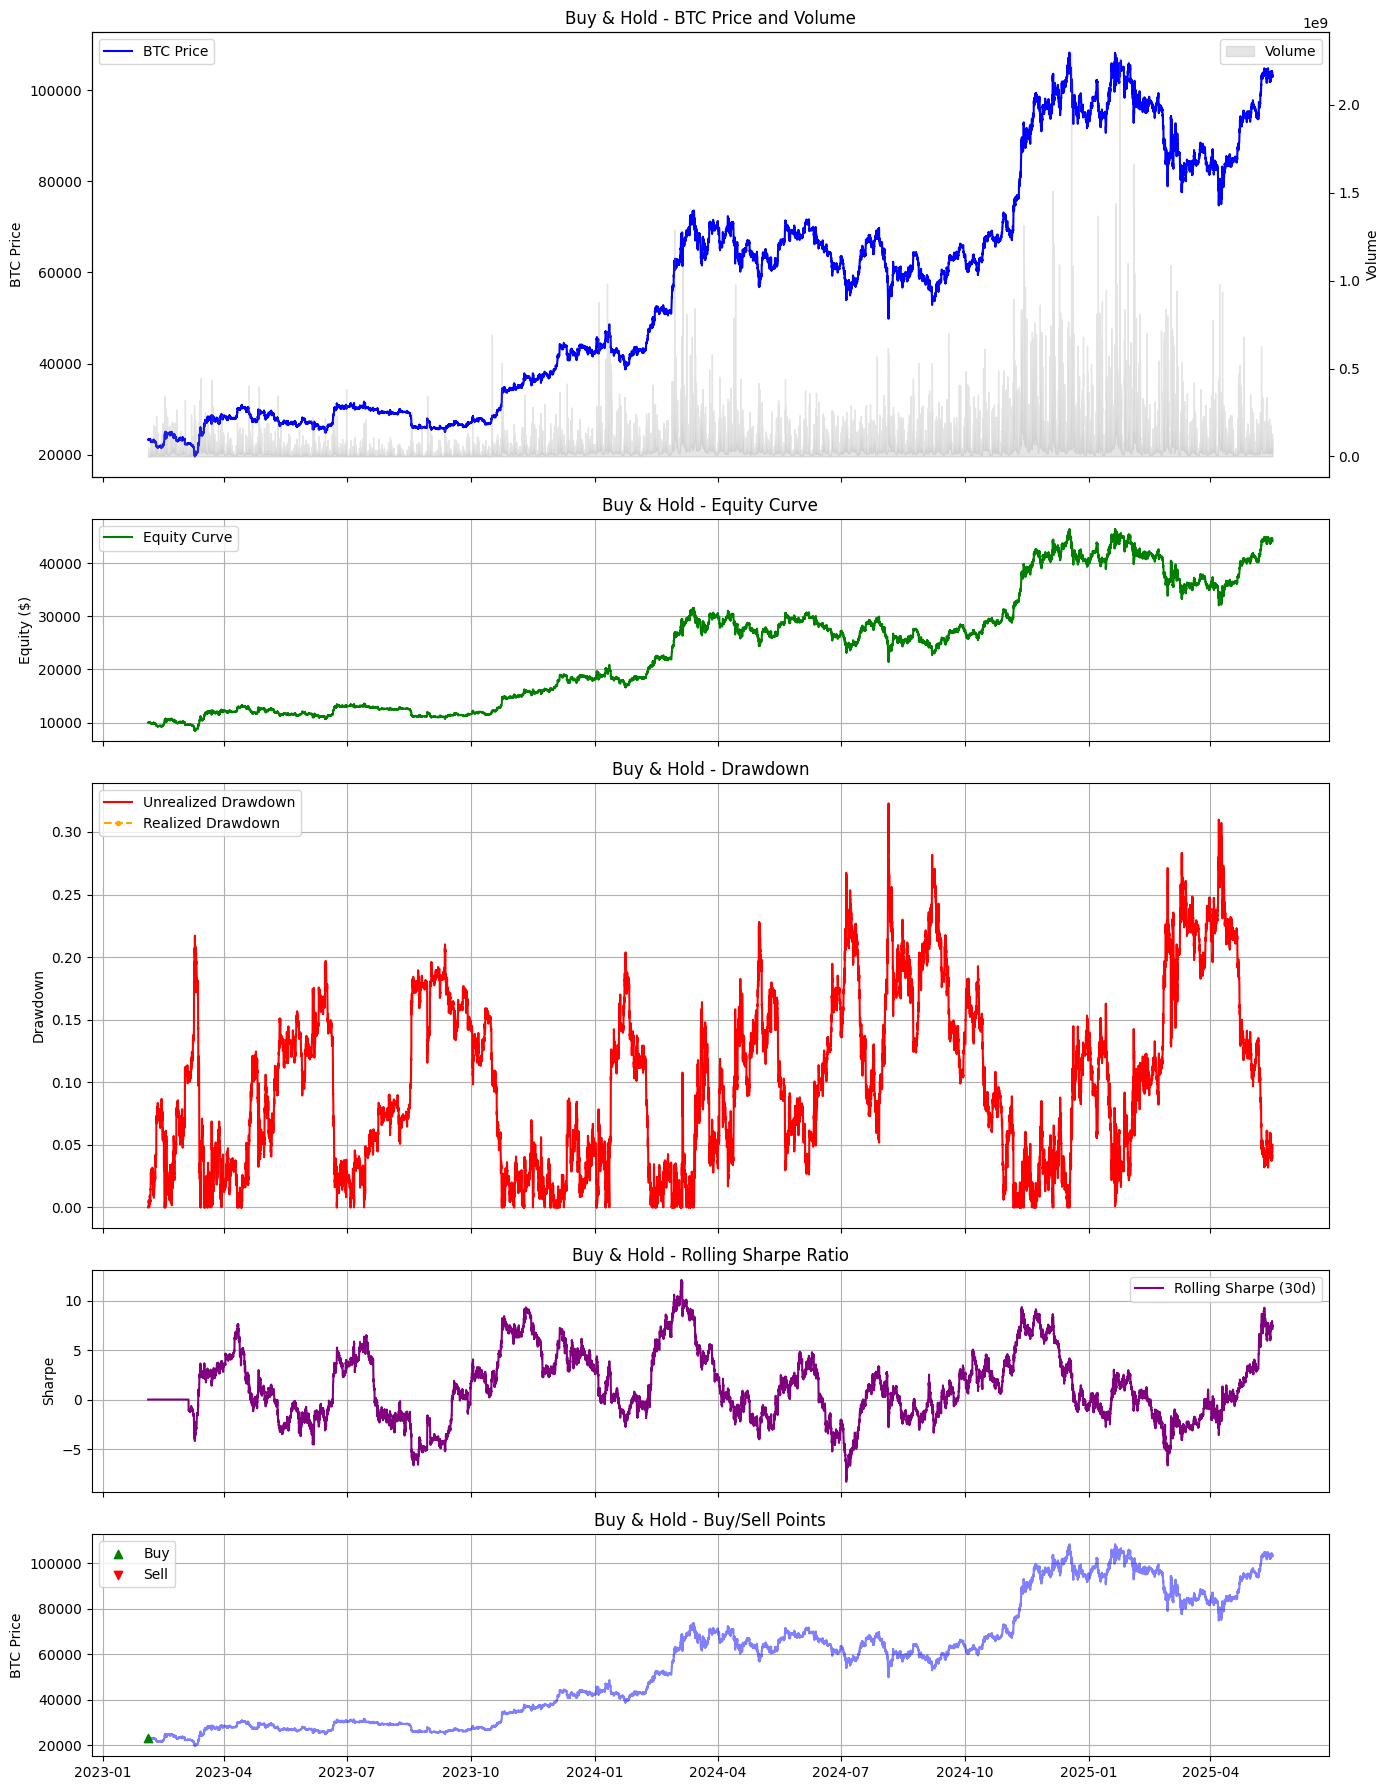

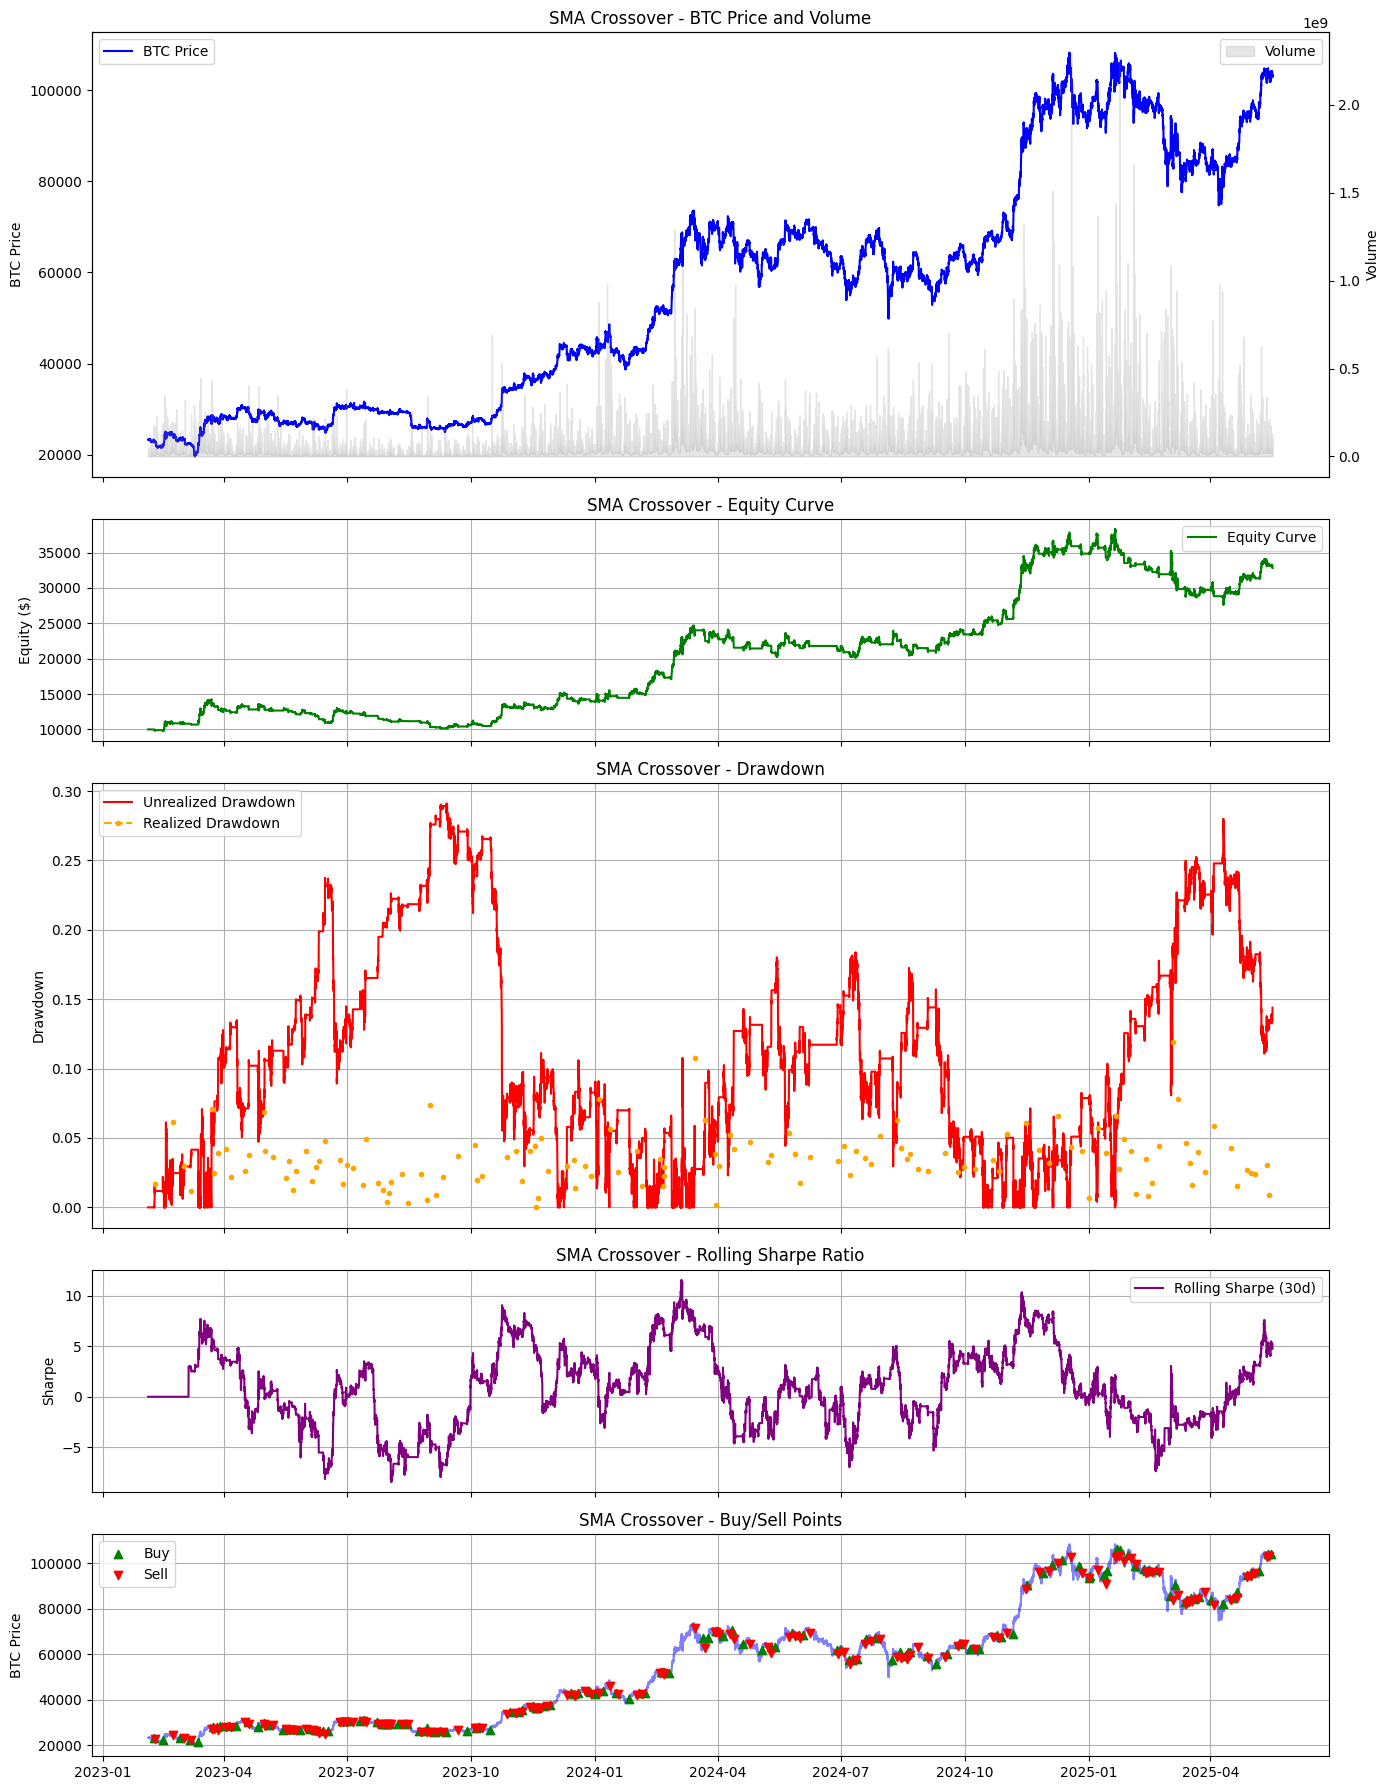

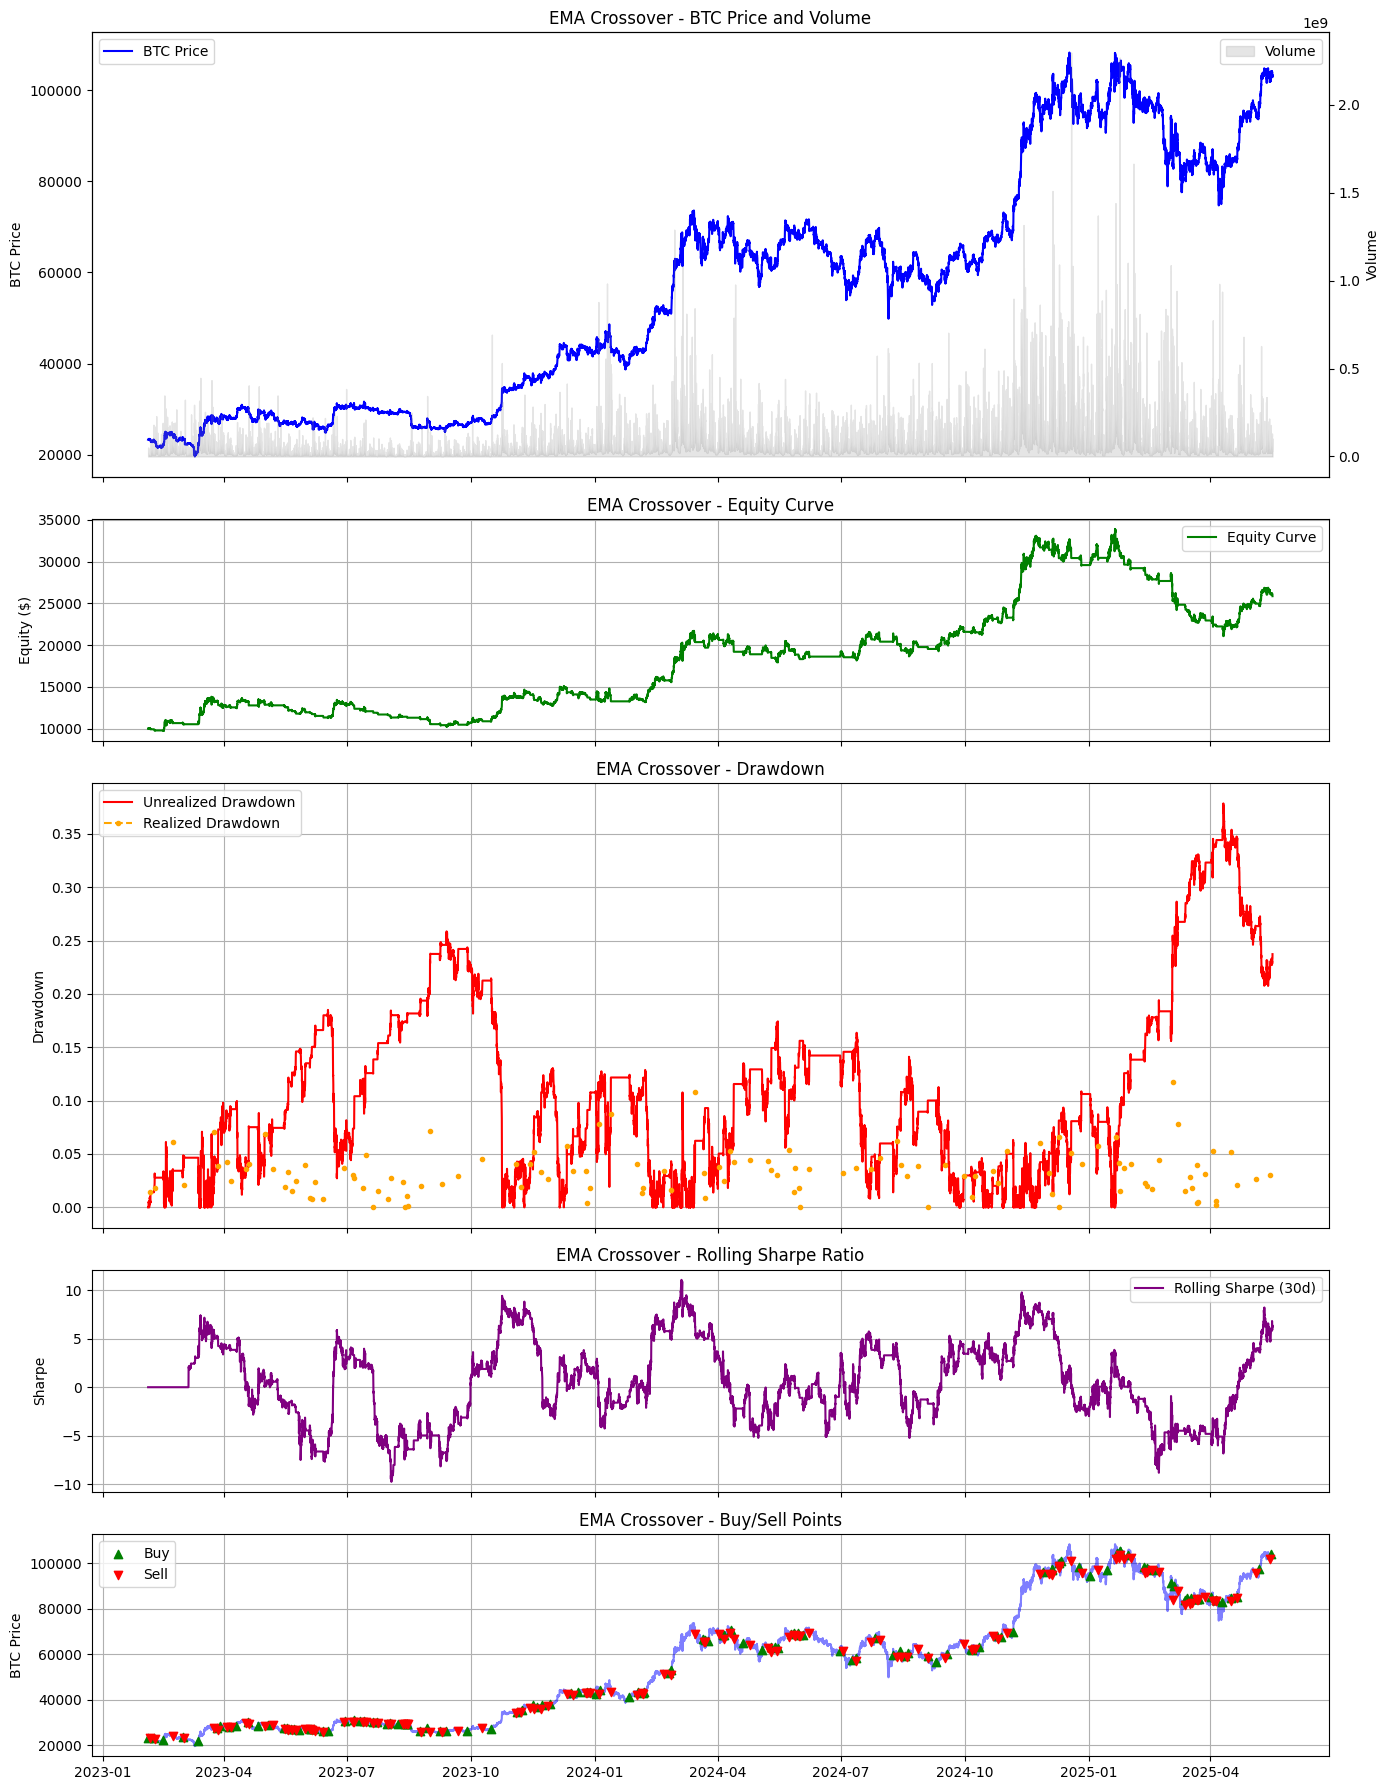

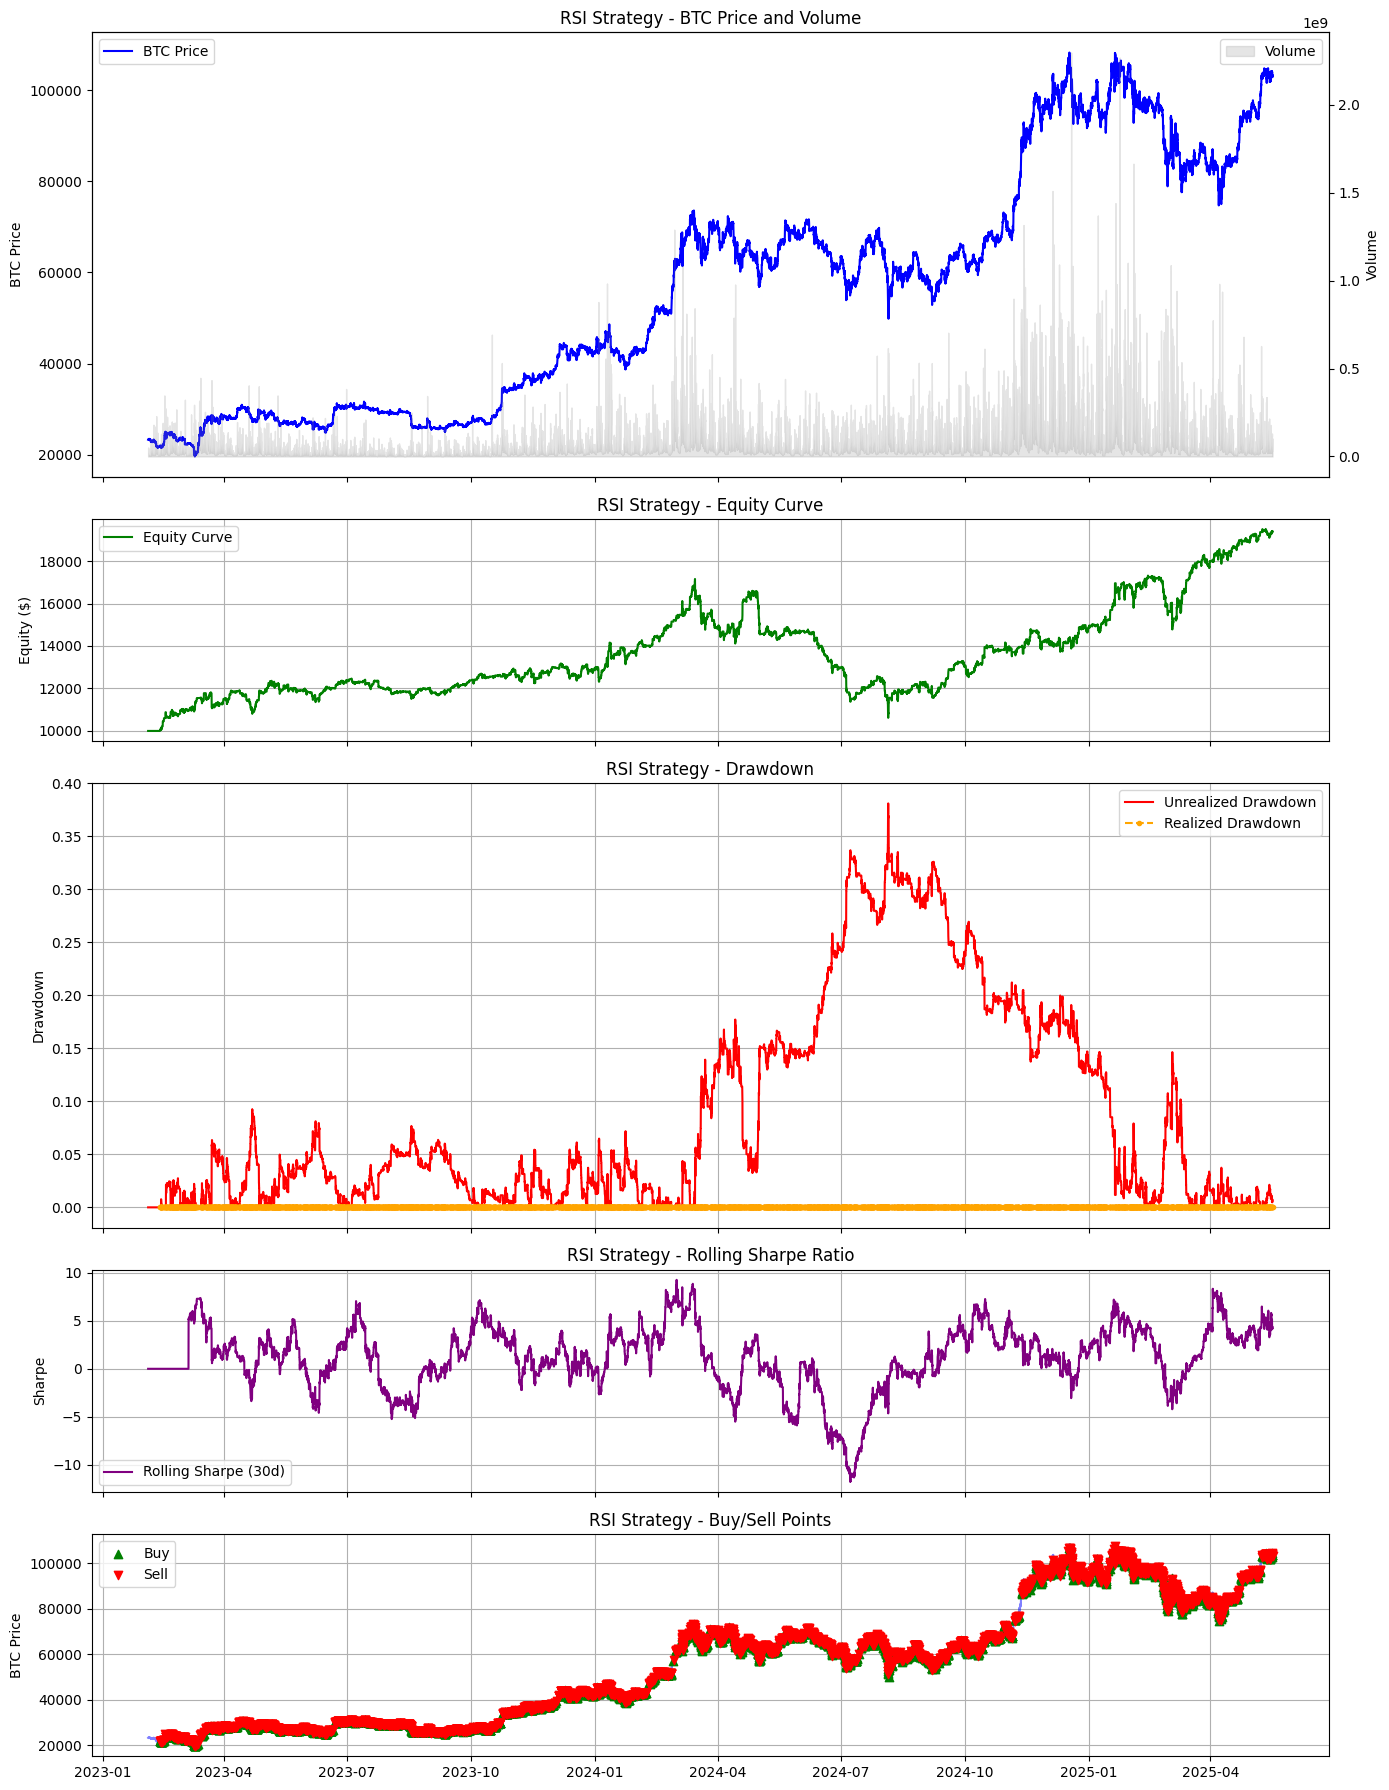

In [102]:
import matplotlib.dates as mdates

def plot_strategy_results(df, results, name="Strategy"):
    # Align index for plotting
    times = pd.to_datetime(df['time'])
    equity = results['equity_curve'].reset_index(drop=True)
    rolling_sharpe = results['rolling_sharpe'].reset_index(drop=True)
    unrealized_dd = results['unrealized_drawdown'].reset_index(drop=True)
    realized_dd = results['realized_drawdown'].reset_index(drop=True)

    fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [2, 1, 2, 1, 1]})

    # 1. Price and Volume
    axs[0].plot(times, df['close'], label='BTC Price', color='blue')
    ax2 = axs[0].twinx()
    ax2.fill_between(times, df['volume'], color='gray', alpha=0.2, label='Volume')
    axs[0].set_ylabel('BTC Price')
    ax2.set_ylabel('Volume')
    axs[0].set_title(f"{name} - BTC Price and Volume")
    axs[0].legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 2. Equity Curve
    axs[1].plot(times, equity[:len(times)], label='Equity Curve', color='green')
    axs[1].set_ylabel('Equity ($)')
    axs[1].set_title(f"{name} - Equity Curve")
    axs[1].legend()
    axs[1].grid(True)

    # 3. Drawdown
    axs[2].plot(times, unrealized_dd[:len(times)], label='Unrealized Drawdown', color='red')
    axs[2].plot(times, realized_dd[:len(times)], label='Realized Drawdown', color='orange', linestyle='--', marker='o', markersize=3)
    axs[2].set_ylabel('Drawdown')
    axs[2].set_title(f"{name} - Drawdown")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Rolling Sharpe
    axs[3].plot(times, rolling_sharpe[:len(times)], label='Rolling Sharpe (30d)', color='purple')
    axs[3].set_ylabel('Sharpe')
    axs[3].set_title(f"{name} - Rolling Sharpe Ratio")
    axs[3].legend()
    axs[3].grid(True)

    # 5. Trades (Buy/Sell markers)
    axs[4].plot(times, df['close'], color='blue', alpha=0.5)
    # Only keep indices that are within the bounds of df/times
    buys = [idx for idx in [t['entry_idx'] for t in results['trades']] if idx < len(df)]
    sells = [idx for idx in [t['exit_idx'] for t in results['trades']] if idx < len(df)]

    axs[4].scatter(times.iloc[buys], df['close'].iloc[buys], marker='^', color='green', label='Buy', zorder=5)
    axs[4].scatter(times.iloc[sells], df['close'].iloc[sells], marker='v', color='red', label='Sell', zorder=5)
    axs[4].set_ylabel('BTC Price')
    axs[4].set_title(f"{name} - Buy/Sell Points")
    axs[4].legend()
    axs[4].grid(True)

    # X-axis formatting
    axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_strategy_results(bt_df, bh_results, name="Buy & Hold")
plot_strategy_results(bt_df, sma_results, name="SMA Crossover")
plot_strategy_results(bt_df, ema_results, name="EMA Crossover")
plot_strategy_results(bt_df, rsi_results, name="RSI Strategy")